In [194]:
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.providers.aer.noise import NoiseModel

from qiskit_ibm_provider import IBMProvider
QISKIT_TOKEN = '3499e541735ebc99f0e45c1edb7342418ef95fd4a176bf3fceb44f3775cd042c2e4bf8d937fbe2f3a1a095add0415819711064ee83bb77bb70ce3842321b9be7'
IBM_PROVIDER = IBMProvider(token=QISKIT_TOKEN)

In [208]:
from qiskit.providers.fake_provider import FakeWashington
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.providers.aer.noise import NoiseModel
from qiskit.transpiler import passes
from qiskit.transpiler.passmanager import PassManager
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from math import pi
import copy

import pickle
from qiskit.quantum_info import partial_trace, Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

simulator = Aer.get_backend('statevector_simulator')

In [209]:
def find_probablity(file, qc, simulator):
    res = []
    partial_circuit = QuantumCircuit()
    for reg in qc.qregs:
        new_reg = QuantumRegister(reg.size, reg.name)
        partial_circuit.add_register(new_reg)
    # print(qc.num_qubits)
    transpile_qc = transpile(qc, simulator)
    for i, gate in enumerate(qc.data):
        # 创建一个新的电路，将所有先前的门加入到新的电路中
        # partial_circuit = QuantumCircuit(qc.num_qubits)
        partial_circuit.data = transpile_qc.data[:i+1]  # 只包含到第 i 步的操作
    
        # 模拟部分电路并获取态向量
        job = simulator.run(partial_circuit)
        result = job.result()
        statevector = result.get_statevector()
        
        # 将态向量转换为量子态对象
        quantum_state = Statevector(statevector)
    
        # 提取与该门操作相关的量子比特的状态
        qubits_involved = [partial_circuit.find_bit(qubit) for qubit in gate[1]]  # 获取与该门相关的量子比特
        for qubit in qubits_involved:
            # 使用 partial_trace 仅提取该量子比特的状态
            qubit_state = partial_trace(quantum_state, [q for q in range(qc.num_qubits) if q != qubit.index])
            prob_zero = qubit_state.data[0, 0].real
            prob_one = qubit_state.data[1, 1].real
            res.append([i, gate[0].name, qubit, prob_zero, prob_one])
    return res

# Get statevector

In [212]:
def main_function():
    f = open('../limited_quantum_circuits/statevector_list.pkl', 'ab+')

    simulator = Aer.get_backend('statevector_simulator')
    
    folder_path = Path("../limited_quantum_circuits/")  # 文件夹路径

    # result = {}

    # 递归遍历文件夹中的所有文件（包括子文件夹）
    for file in folder_path.rglob('*'):
        if file.is_file() and file.suffix == '.qasm':  # 检查文件是否以 .qasm 结尾
            print(file)
            try:
                qc = QuantumCircuit.from_qasm_file(file)
            except Exception as e:
                print(e)
                continue

            pm = PassManager(passes.RemoveFinalMeasurements())
            qc = pm.run(qc)

            res = find_probablity(file, qc, simulator)
            # print(res)
            # result[file] = res
            # print(result)
            # return
    
            pickle.dump([file, res], f)
            # break
    f.close()
            
    #         if find_def_state(qc, simulator):
    #             num += 1
            
    #         print(num)
    # return num
                

In [213]:
# main_function()

../limited_quantum_circuits/qnn_indep_qiskit_8.qasm
../limited_quantum_circuits/qaoa_indep_qiskit_6.qasm
../limited_quantum_circuits/ghz_indep_qiskit_9.qasm
../limited_quantum_circuits/portfoliovqe_indep_qiskit_8.qasm
../limited_quantum_circuits/qpeexact_indep_qiskit_5.qasm
../limited_quantum_circuits/su2random_indep_qiskit_4.qasm
../limited_quantum_circuits/ae_indep_qiskit_8.qasm
../limited_quantum_circuits/qnn_indep_qiskit_10.qasm
../limited_quantum_circuits/qftentangled_indep_qiskit_6.qasm
../limited_quantum_circuits/groundstate_small_indep_qiskit_4.qasm
../limited_quantum_circuits/qnn_indep_qiskit_4.qasm
../limited_quantum_circuits/ghz_indep_qiskit_5.qasm
../limited_quantum_circuits/dj_indep_qiskit_10.qasm
../limited_quantum_circuits/qft_indep_qiskit_7.qasm
../limited_quantum_circuits/qpeexact_indep_qiskit_9.qasm
../limited_quantum_circuits/portfoliovqe_indep_qiskit_4.qasm
../limited_quantum_circuits/su2random_indep_qiskit_8.qasm
../limited_quantum_circuits/realamprandom_indep_qisk

# Get the circuits with monitoring nodes

In [199]:
simulator = Aer.get_backend('statevector_simulator')
quantum_file = {}
num = 0
count = 0

unwanted_circuit_set = set()
with open('../limited_quantum_circuits/statevector_list.pkl', 'rb') as f:
    while True:
        try:
            item = pickle.load(f)
            # list = []
            qc = QuantumCircuit.from_qasm_file(item[0])
            
            last_gate_index_before_measurement = [None] * qc.num_qubits
            # flag = False
            for i, gate in enumerate(transpile(qc, simulator).data):
                if gate[0].name in ['swap', 'ccx']:
                    unwanted_circuit_set.add(item[0])
                    # flag = True
                    # break
                if gate[0].name not in ['measure', 'barrier']:
                    for qubit in gate[1]:
                        # print(transpile(qc, simulator).find_bit(qubit))
                        last_gate_index_before_measurement[transpile(qc, simulator).find_bit(qubit).index] = i

            # if flag:
            #     continue
            for l in item[1]:
                if l[0] == last_gate_index_before_measurement[l[2].index]:
                    continue
                if l[3] >= 0.99 or l[4] >= 0.99:
                    # list.append([item[0], l])
                    num += 1
                    if item[0] not in quantum_file:
                        quantum_file[item[0]] = 0
                    quantum_file[item[0]] += 1
                    # print(item[0], l)
                    # break
            # if list:
            #     print(list, '\n')
            if item[0] in quantum_file:
                count += 1
        except EOFError:
            break

print(num)
print(count)

2589
81


In [149]:
len([key for key in quantum_file if str(key) not in unwanted_circuit_list])

63

In [120]:
unwanted_circuit_list = []
with open('../limited_quantum_circuits/statevector_list.pkl', 'rb') as f:
    while True:
        try:
            item = pickle.load(f)
            # list = []
            qc = QuantumCircuit.from_qasm_file(item[0])
            for i, gate in enumerate(transpile(qc, simulator).data):
                if gate[0].name == 'ccx':
                    unwanted_circuit_list.append(str(item[0]))
                    break
        except EOFError:
            break

In [121]:
len(unwanted_circuit_list)

17

In [122]:
quantum_file

{PosixPath('../limited quantum circuits/portfoliovqe_indep_qiskit_8.qasm'): 32,
 PosixPath('../limited quantum circuits/twolocalrandom_indep_qiskit_3.qasm'): 1,
 PosixPath('../limited quantum circuits/qpeexact_indep_qiskit_5.qasm'): 10,
 PosixPath('../limited quantum circuits/su2random_indep_qiskit_4.qasm'): 4,
 PosixPath('../limited quantum circuits/ae_indep_qiskit_8.qasm'): 6,
 PosixPath('../limited quantum circuits/qft_indep_qiskit_7.qasm'): 21,
 PosixPath('../limited quantum circuits/qpeexact_indep_qiskit_9.qasm'): 35,
 PosixPath('../limited quantum circuits/portfoliovqe_indep_qiskit_4.qasm'): 16,
 PosixPath('../limited quantum circuits/su2random_indep_qiskit_8.qasm'): 3,
 PosixPath('../limited quantum circuits/realamprandom_indep_qiskit_10.qasm'): 11,
 PosixPath('../limited quantum circuits/ae_indep_qiskit_4.qasm'): 2,
 PosixPath('../limited quantum circuits/random_indep_qiskit_6.qasm'): 22,
 PosixPath('../limited quantum circuits/vqe_indep_qiskit_6.qasm'): 11,
 PosixPath('../limi

In [45]:
with open('../data/quantum_file.pkl', 'wb') as pickle_file:
    pickle.dump(quantum_file, pickle_file)

In [9]:
with open('../data/quantum_file.pkl', 'rb') as pickle_file:
    quantum_file = pickle.load(pickle_file)

# Filter the circuits

In [200]:
filetered_quantum_file = {}
for key, value in quantum_file.items():
    qc = QuantumCircuit.from_qasm_file(key)
    backend = Aer.get_backend('qasm_simulator')  # 使用模拟器
    result = execute(qc, backend, shots=8192).result()
    counts = result.get_counts()
    # if len(counts) <= 10:
    #     filetered_quantum_file[key] = counts
    filetered_quantum_file[key] = counts

# filetered_quantum_file

In [24]:
with open('../data/filetered_quantum_file.pkl', 'wb') as pickle_file:
    pickle.dump(filetered_quantum_file, pickle_file)

In [45]:
with open('../data/filetered_quantum_file.pkl', 'rb') as pickle_file:
    filetered_quantum_file = pickle.load(pickle_file)

In [7]:
# filetered_quantum_file = {}
# for key, value in quantum_file.items():
#     qc = QuantumCircuit.from_qasm_file(key)
#     backend = Aer.get_backend('qasm_simulator')  # 使用模拟器
#     result = execute(transpile(qc, backend, basis_gates=['id', 'rz', 'sx', 'x', 'cx', 'reset']), backend, shots=8192).result()
#     counts = result.get_counts()
#     if len(counts) <= 10:
#         filetered_quantum_file[key] = counts
#         # print(key, counts)
#     # filetered_quantum_file[key] = counts

# Get the node with certain probability

In [201]:
definited_node_dict = {}
simulator = Aer.get_backend('qasm_simulator')
count = 0
with open('../limited_quantum_circuits/statevector_list.pkl', 'rb') as f:
    while True:
        try:
            item = pickle.load(f)
            if item[0] not in filetered_quantum_file:
                continue
            # print(item[0])
            qc = QuantumCircuit.from_qasm_file(item[0])
            
            last_gate_index_before_measurement = [None] * qc.num_qubits
            for i, gate in enumerate(transpile(qc, simulator).data):
                if gate[0].name not in ['measure', 'barrier']:
                    for qubit in gate[1]:
                        # print(transpile(qc, simulator).find_bit(qubit))
                        last_gate_index_before_measurement[transpile(qc, simulator).find_bit(qubit).index] = i
                        
            num = 0
            for l in item[1]:
                if l[0] == last_gate_index_before_measurement[l[2].index]:
                    continue
                if l[3] >= 0.99 or l[4] >= 0.99:
                    # if l[1] in ['x', 'h'] or (l[1] == 'cp' and l[2].registers[0][0].name != 'q'):
                    gate = transpile(qc, simulator).data[l[0]]
                    print(l, gate)
                    num += 1
                    if str(item[0]) not in definited_node_dict:
                        definited_node_dict[str(item[0])] = []
                    definited_node_dict[str(item[0])].append([l[0], l[1], l[2], l[3], l[4], gate[0].num_qubits, gate[0].params,\
                                                              l[2] == qc.find_bit(gate.qubits[0])])
            if num > 0:
                count += 1
        except EOFError:
            break
print(count)

[28, 'ry', BitLocations(index=7, registers=[(QuantumRegister(8, 'q'), 7)]), 0.9998227680878257, 0.0001772319121745584] CircuitInstruction(operation=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[6.256558825358066]), qubits=(Qubit(QuantumRegister(8, 'q'), 7),), clbits=())
[29, 'cz', BitLocations(index=7, registers=[(QuantumRegister(8, 'q'), 7)]), 0.9998227680878257, 0.0001772319121745584] CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(8, 'q'), 0), Qubit(QuantumRegister(8, 'q'), 7)), clbits=())
[31, 'cz', BitLocations(index=7, registers=[(QuantumRegister(8, 'q'), 7)]), 0.9998227680878257, 0.0001772319121745584] CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(8, 'q'), 1), Qubit(QuantumRegister(8, 'q'), 7)), clbits=())
[34, 'cz', BitLocations(index=7, registers=[(QuantumRegister(8, 'q'), 7)]), 0.9998227680878261, 0.0001772319121745

In [26]:
with open('../data/definited_node_dict.pkl', 'wb') as pickle_file:
    pickle.dump(definited_node_dict, pickle_file)

In [46]:
with open('../data/definited_node_dict.pkl', 'rb') as pickle_file:
    definited_node_dict = pickle.load(pickle_file)

In [83]:
definited_node_dict['../limited_quantum_circuits/random_indep_qiskit_6.qasm']

[[2,
  'cx',
  BitLocations(index=2, registers=[(QuantumRegister(6, 'q'), 2)]),
  1.0,
  0.0,
  2,
  [],
  True],
 [4,
  'tdg',
  BitLocations(index=3, registers=[(QuantumRegister(6, 'q'), 3)]),
  0.9999999999999999,
  0.0,
  1,
  [],
  True],
 [5,
  'u1',
  BitLocations(index=4, registers=[(QuantumRegister(6, 'q'), 4)]),
  0.9999999999999999,
  0.0,
  1,
  [-1.4903425489366011],
  True],
 [9,
  'cx',
  BitLocations(index=4, registers=[(QuantumRegister(6, 'q'), 4)]),
  1.0,
  2.0046179770394127e-33,
  2,
  [],
  False],
 [10,
  'u2',
  BitLocations(index=1, registers=[(QuantumRegister(6, 'q'), 1)]),
  1.0,
  8.653421781598837e-33,
  1,
  [-3.141592653589793, -3.141592653589793],
  True],
 [11,
  'u1',
  BitLocations(index=4, registers=[(QuantumRegister(6, 'q'), 4)]),
  1.0,
  2.0046179770394123e-33,
  1,
  [-2.9840376505936677],
  True],
 [12,
  'crz',
  BitLocations(index=3, registers=[(QuantumRegister(6, 'q'), 3)]),
  0.9999999999999999,
  0.0,
  2,
  [-1.8088051076493177],
  True],


In [91]:
for key, value in definited_node_dict.items():
    # print(key)
    qc = QuantumCircuit.from_qasm_file(key)
    transpiled_qc = transpile(qc, simulator)
    for node in value:
        index = node[0]
        # if index != 15:
        #     continue
        gate_name = node[1]
        qubit_info = node[2]
        p0 = node[3]
        p1 = node[4]
        num_qubits = node[5]
        parameters = node[6]
       
        if gate_name != transpiled_qc.data[index][0].name:
            print(key)
            break

../limited quantum circuits/random_indep_qiskit_6.qasm
../limited quantum circuits/random_indep_qiskit_7.qasm
../limited quantum circuits/pricingcall_indep_qiskit_5.qasm
../limited quantum circuits/pricingcall_indep_qiskit_9.qasm
../limited quantum circuits/grover-v-chain_indep_qiskit_9.qasm
../limited quantum circuits/pricingput_indep_qiskit_5.qasm
../limited quantum circuits/grover-v-chain_indep_qiskit_5.qasm
../limited quantum circuits/pricingput_indep_qiskit_9.qasm
../limited quantum circuits/random_indep_qiskit_10.qasm
../limited quantum circuits/pricingcall_indep_qiskit_7.qasm
../limited quantum circuits/pricingput_indep_qiskit_7.qasm
../limited quantum circuits/grover-v-chain_indep_qiskit_7.qasm
../limited quantum circuits/random_indep_qiskit_8.qasm
../limited quantum circuits/random_indep_qiskit_5.qasm
../limited quantum circuits/random_indep_qiskit_9.qasm


# DFS to track the path

In [202]:
from qiskit import QuantumCircuit

# Function to perform Depth-First Search (DFS) on the quantum circuit
def dfs_quantum_circuit(transpiled_qc, qubit_info, current_index, visited, path):
    # Iterate backward through the circuit instructions
    for index in range(current_index, -1, -1):
        if [index, qubit_info] in visited:
            continue
        gate, qargs, cargs = transpiled_qc.data[index]
        qubit_indices = [transpiled_qc.find_bit(qubit) for qubit in qargs]
        if qubit_info in qubit_indices:
            # Handle multi-qubit gates
            if len(qubit_indices) > 1:
                if gate.name == "swap":
                    # Special handling for swap gate
                    path.insert(0, [index, gate.name, gate.params, qubit_indices])
                    other_qubit = qubit_indices[0] if qubit_indices[1] == qubit_info else qubit_indices[1]
                    dfs_quantum_circuit(transpiled_qc, other_qubit, index - 1, visited, path)
                    # path.sort()
                    break
                elif gate.name == "iswap":
                    print(gate.name)
                elif qubit_info == qubit_indices[0]:
                    # If the qubit is the control qubit, this gate does not affect the qubit's state
                    continue
                else:
                    # Handle other multi-qubit gates (e.g., cx, cz, etc.)
                    for q in qubit_indices:
                        if q != qubit_info:
                            path.insert(0, [index, gate.name, gate.params, qubit_indices, dfs_quantum_circuit(transpiled_qc, q, index - 1, visited, [])])
            # Record the current gate if it affects the qubit
            else:
                path.insert(0, [index, gate.name, gate.params, qubit_indices])
            # path.sort()
            visited.append([index, qubit_info])
    return path

In [203]:
final_definited_node_dict = {}
for key, value in definited_node_dict.items():
    # if key in ['../limited_quantum_circuits/grover-v-chain_indep_qiskit_9.qasm', 
    #            '../limited_quantum_circuits/grover-noancilla_indep_qiskit_6.qasm']:
    #     continue
    # if key != '../quantum_circuits/qpeexact_indep_qiskit_5.qasm':
    #     continue
    # if key == '../quantum_circuits/grover-noancilla_indep_qiskit_6.qasm':
    #     continue
    # if key != '../quantum_circuits/random_indep_qiskit_2.qasm':
    #     continue
    print(key)
    qc = QuantumCircuit.from_qasm_file(key)
    transpiled_qc = transpile(qc, simulator)
    for node in value:
        index = node[0]
        # if index != 15:
        #     continue
        gate_name = node[1]
        qubit_info = node[2]
        p0 = node[3]
        p1 = node[4]
        num_qubits = node[5]
        parameters = node[6]

        dfs_path = []
        visited = list()
        path = []
        # Perform DFS on the circuit
        dfs_path = dfs_quantum_circuit(transpiled_qc, qubit_info, index, visited, path)
        # gate_list = find_operated_gates(transpiled_qc, gate_list, 0, index + 1, qubit_info)
        # print(gate_list)

        if key not in final_definited_node_dict:
            final_definited_node_dict[key] = []
        final_definited_node_dict[key].append([index, gate_name, qubit_info, p0, p1, dfs_path])

../limited quantum circuits/portfoliovqe_indep_qiskit_8.qasm
../limited quantum circuits/qpeexact_indep_qiskit_5.qasm
../limited quantum circuits/su2random_indep_qiskit_4.qasm
../limited quantum circuits/qft_indep_qiskit_7.qasm
../limited quantum circuits/qpeexact_indep_qiskit_9.qasm
../limited quantum circuits/su2random_indep_qiskit_8.qasm
../limited quantum circuits/realamprandom_indep_qiskit_10.qasm
../limited quantum circuits/random_indep_qiskit_6.qasm
../limited quantum circuits/vqe_indep_qiskit_6.qasm
../limited quantum circuits/twolocalrandom_indep_qiskit_10.qasm
../limited quantum circuits/vqe_indep_qiskit_7.qasm
../limited quantum circuits/random_indep_qiskit_7.qasm
../limited quantum circuits/su2random_indep_qiskit_9.qasm
../limited quantum circuits/portfoliovqe_indep_qiskit_5.qasm
../limited quantum circuits/qpeexact_indep_qiskit_8.qasm
../limited quantum circuits/qft_indep_qiskit_6.qasm
../limited quantum circuits/su2random_indep_qiskit_5.qasm
../limited quantum circuits/qp

In [30]:
with open('../final_definited_node_dict.pkl', 'wb') as pickle_file:
    pickle.dump(final_definited_node_dict, pickle_file)

In [ ]:
with open('../final_definited_node_dict.pkl', 'rb') as pickle_file:
    final_definited_node_dict = pickle.load(pickle_file)

In [73]:
final_definited_node_dict['../limited_quantum_circuits/qpeexact_indep_qiskit_5.qasm']

[[4,
  'x',
  BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]),
  0.0,
  1.0,
  [[4,
    'x',
    [],
    [BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)])]]]],
 [5,
  'cp',
  BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]),
  0.0,
  1.0,
  [[4,
    'x',
    [],
    [BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)])]]]],
 [6,
  'cp',
  BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]),
  0.0,
  1.0,
  [[4,
    'x',
    [],
    [BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)])]]]],
 [7,
  'cp',
  BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]),
  0.0,
  1.0,
  [[4,
    'x',
    [],
    [BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)])]]]],
 [10,
  'h',
  BitLocations(index=0, registers=[(QuantumRegister(4, 'q'), 0)]),
  3.6490208511237654e-32,
  1.0,
  [[3,
    'h',
    [],
    [BitLocations(index=3, registers=[(QuantumRegister(4, 'q'), 3)])]],
   [8,
 

# Transform the gatelist

In [204]:
def transformation(transpiled_qc, swap_qubit_info, qubit_info, gate_list, opeartion_list):
    print('<<<<<<<<>>>>>>>>>>>', '\n')
    print(gate_list)
    print('<<<<<<<<>>>>>>>>>>>', '\n')
    if not gate_list:
        return opeartion_list
    for gate in gate_list:
        if gate[1] == 'swap':
            print('$%$^%$&%&', gate, '$%$^%$&%&', '\n')
            for qubit in gate[3]:
                if swap_qubit_info != qubit:
                    swap_qubit_info = qubit
                    print('~~~~~~~~~~~~~', swap_qubit_info, '~~~~~~~~~~~~~', '\n')
                    break
    
    for gate in gate_list:
        print('@@@@@@@@@@@@@', gate, '@@@@@@@@@@@@@')
        if not gate or gate[1] == 'swap':
            continue
        
        if len(gate) == 4:
            flag = True
            for qubit in gate[3]:
               if qubit_info == qubit:
                   flag = False
            if flag:
                opeartion_list.append([gate[0], gate[1], gate[2], [qubit_info if swap_qubit_info == qubit else qubit for qubit in gate[3]]])
            else:
                opeartion_list.append([gate[0], gate[1], gate[2], [qubit for qubit in gate[3]]])
            
        else:
            control_qubit_info = None
            control_gate = []
            flag = True
            for qubit in gate[3]:
                if qubit_info == qubit:
                    flag = False
            if flag:
                target_gate = [gate[0], gate[1], gate[2], [qubit_info if swap_qubit_info == qubit else qubit for qubit in gate[3]]]
            else:
                target_gate = [gate[0], gate[1], gate[2], [qubit for qubit in gate[3]]]

            print('=================', target_gate, '=================')
            control_qubit_info = gate[3][0]
           
            control_control_gate = transformation(transpiled_qc, control_qubit_info, control_qubit_info, gate[4], [])
            control_gate.extend(control_control_gate)
            
            target_gate.extend([control_gate])
            opeartion_list.append(target_gate)
    return opeartion_list

In [205]:
def bulid_partial_circuit(final_definited_node_dict):
    res = {}
    for key, value in final_definited_node_dict.items():
        # if key != '../quantum_circuits/qpeexact_indep_qiskit_5.qasm':
        #     continue
        # if key != '../quantum_circuits/random_indep_qiskit_2.qasm':
        #     continue
        print(key, '\n')
        # if key == '../quantum_circuits/qft_indep_qiskit_3.qasm':
        #     continue
        qc = QuantumCircuit.from_qasm_file(key)
        transpiled_qc = transpile(qc, simulator)
        for node in value:
            if not node[-1]:
                continue
            # if node[0] != 10:
            #     continue
            # print('*****************************')
            # print(node)
            # print('*****************************')
            # if node[0] != 4:
            #     continue
            # print(node, '\n')

            index = node[0]
            gate_name = node[1]
            qubit_info = node[2]
            p0 = node[3]
            p1 = node[4]

            opeartion_list = []
            
            swap_qubit_info = qubit_info = node[2]
            opeartion_list = transformation(transpiled_qc, swap_qubit_info, qubit_info, node[-1], opeartion_list)

            if key not in res:
                res[key] = []
            res[key].append([index, gate_name, qubit_info, p0, p1, opeartion_list])
    
    return res
            # break

In [206]:
import pickle
# with open('../data/final_definited_node_dict.pkl', 'rb') as file:  # 确保文件扩展名是.pkl如果它是pickle文件
#     final_definited_node_dict = pickle.load(file)
# del list
test = copy.deepcopy(final_definited_node_dict)
res = bulid_partial_circuit(test)

../limited quantum circuits/portfoliovqe_indep_qiskit_8.qasm 

<<<<<<<<>>>>>>>>>>> 

[[28, 'ry', [6.256558825358066], [BitLocations(index=7, registers=[(QuantumRegister(8, 'q'), 7)])]]]
<<<<<<<<>>>>>>>>>>> 

@@@@@@@@@@@@@ [28, 'ry', [6.256558825358066], [BitLocations(index=7, registers=[(QuantumRegister(8, 'q'), 7)])]] @@@@@@@@@@@@@
<<<<<<<<>>>>>>>>>>> 

[[28, 'ry', [6.256558825358066], [BitLocations(index=7, registers=[(QuantumRegister(8, 'q'), 7)])]], [29, 'cz', [], [BitLocations(index=0, registers=[(QuantumRegister(8, 'q'), 0)]), BitLocations(index=7, registers=[(QuantumRegister(8, 'q'), 7)])], [[0, 'ry', [-2.157666746655994], [BitLocations(index=0, registers=[(QuantumRegister(8, 'q'), 0)])]]]]]
<<<<<<<<>>>>>>>>>>> 

@@@@@@@@@@@@@ [28, 'ry', [6.256558825358066], [BitLocations(index=7, registers=[(QuantumRegister(8, 'q'), 7)])]] @@@@@@@@@@@@@
@@@@@@@@@@@@@ [29, 'cz', [], [BitLocations(index=0, registers=[(QuantumRegister(8, 'q'), 0)]), BitLocations(index=7, registers=[(QuantumRegiste

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



<<<<<<<<>>>>>>>>>>> 

[[15, 'ry', [-3.3353970476601047], [BitLocations(index=5, registers=[(QuantumRegister(6, 'q'), 5)])]]]
<<<<<<<<>>>>>>>>>>> 

@@@@@@@@@@@@@ [15, 'ry', [-3.3353970476601047], [BitLocations(index=5, registers=[(QuantumRegister(6, 'q'), 5)])]] @@@@@@@@@@@@@
<<<<<<<<>>>>>>>>>>> 

[[15, 'ry', [-3.3353970476601047], [BitLocations(index=5, registers=[(QuantumRegister(6, 'q'), 5)])]], [16, 'cz', [], [BitLocations(index=0, registers=[(QuantumRegister(6, 'q'), 0)]), BitLocations(index=5, registers=[(QuantumRegister(6, 'q'), 5)])], [[0, 'ry', [0.6572088955750814], [BitLocations(index=0, registers=[(QuantumRegister(6, 'q'), 0)])]]]]]
<<<<<<<<>>>>>>>>>>> 

@@@@@@@@@@@@@ [15, 'ry', [-3.3353970476601047], [BitLocations(index=5, registers=[(QuantumRegister(6, 'q'), 5)])]] @@@@@@@@@@@@@
@@@@@@@@@@@@@ [16, 'cz', [], [BitLocations(index=0, registers=[(QuantumRegister(6, 'q'), 0)]), BitLocations(index=5, registers=[(QuantumRegister(6, 'q'), 5)])], [[0, 'ry', [0.6572088955750814], [Bit

In [207]:
with open('../limited_quantum_circuits/opeartion_list_99.pkl', 'wb') as pickle_file:
    pickle.dump(res, pickle_file)

In [14]:
with open('../data/opeartion_list.pkl', 'rb') as pickle_file:
    res = pickle.load(pickle_file)

In [84]:
def calculate_num_of_extra_qubits(gate_list, qubit_index, eq_container, num_container, node_index):
    if node_index not in eq_container:
        eq_container[node_index] = {}
    for gate in gate_list:
        ind = num_container[0]
        if not gate:
            continue
        # print(gate)
        # print('********************')
        for qubit in gate[3]:
            if qubit.index != qubit_index:
                if qubit.index not in eq_container[node_index]:
                    eq_container[node_index][qubit.index] = ind
                    num_container[0] += 1
        if len(gate) == 5 and gate[4]:
            for cg in gate[4]:
                # print(cg)
                # print('++++++++++++++++++++')
                for qubit in cg[3]:
                    if qubit.index != qubit_index:
                        if qubit.index not in eq_container[node_index]:
                            eq_container[node_index][qubit.index] = ind
                            num_container[0] += 1
                if len(cg) == 5 and cg[4]:
                    calculate_num_of_extra_qubits(cg[4], qubit_index, eq_container, num_container, node_index)

operation_list = []
eq_container = {}
num_container = [0]
result = 0
for i, gate_list in enumerate(res['../quantum_circuits/qpeexact_indep_qiskit_5.qasm']):
    if len(gate_list[-1]) in range(0, 1000):
        # print(gate_list)
        # print(';;;;;;;;;;;;;;;;;;;;;;')
        # print('\n')
        operation_list.append(gate_list)
        # if i[1] in ['cp', 'cx']:
        #     num_container[0] += 1
        
        calculate_num_of_extra_qubits(gate_list[-1], gate_list[2].index, eq_container, num_container, i)

print(num_container[0])

def fliter_res(file, num=1000):
    operation_list = []
    eq_container = {}
    num_container = [0]
    result = 0
    for i, gate_list in enumerate(res[file]):
        if len(gate_list[-1]) in range(0, num):
            operation_list.append(gate_list)
            
            calculate_num_of_extra_qubits(gate_list[-1], gate_list[2].index, eq_container, num_container, i)
    
    return num_container[0]

7


In [85]:
operation_list

[[4,
  'x',
  BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]),
  0.0,
  1.0,
  [[4,
    'x',
    [],
    [BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)])]]]],
 [6,
  'cp',
  BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]),
  0.0,
  1.0,
  [[4,
    'x',
    [],
    [BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)])]]]],
 [10,
  'h',
  BitLocations(index=0, registers=[(QuantumRegister(4, 'q'), 0)]),
  3.649020851123765e-32,
  1.0,
  [[3,
    'h',
    [],
    [BitLocations(index=0, registers=[(QuantumRegister(4, 'q'), 0)])]],
   [8,
    'cp',
    [3.141592653589793],
    [BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]),
     BitLocations(index=0, registers=[(QuantumRegister(4, 'q'), 0)])],
    [[4,
      'x',
      [],
      [BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)])]]]],
   [10,
    'h',
    [],
    [BitLocations(index=0, registers=[(QuantumRegister(4, 'q'), 0)])]]]],
 [13,
  '

In [92]:
len(res)

100

In [102]:
res_new = {}
for key, value in res.items():
    if fliter_res(key) <= 0 and key not in [str(i) for i in unwanted_circuit_list]:
    # if key not in unwanted_circuit_list:
    # if fliter_res(key) <= 20:
        res_new[key] = value


In [103]:
len(res_new)

40

In [104]:
[key for key in res_new]

['../quantum circuits/qpeinexact_indep_qiskit_13.qasm',
 '../quantum circuits/vqe_indep_qiskit_6.qasm',
 '../quantum circuits/qpeinexact_indep_qiskit_12.qasm',
 '../quantum circuits/qpeexact_indep_qiskit_4.qasm',
 '../quantum circuits/qpeinexact_indep_qiskit_15.qasm',
 '../quantum circuits/qpeinexact_indep_qiskit_6.qasm',
 '../quantum circuits/qpeexact_indep_qiskit_13.qasm',
 '../quantum circuits/qpeexact_indep_qiskit_3.qasm',
 '../quantum circuits/qpeinexact_indep_qiskit_19.qasm',
 '../quantum circuits/qpeinexact_indep_qiskit_18.qasm',
 '../quantum circuits/qpeexact_indep_qiskit_2.qasm',
 '../quantum circuits/qpeexact_indep_qiskit_12.qasm',
 '../quantum circuits/vqe_indep_qiskit_16.qasm',
 '../quantum circuits/qpeinexact_indep_qiskit_7.qasm',
 '../quantum circuits/qpeinexact_indep_qiskit_14.qasm',
 '../quantum circuits/random_indep_qiskit_10.qasm',
 '../quantum circuits/qpeinexact_indep_qiskit_4.qasm',
 '../quantum circuits/random_indep_qiskit_2.qasm',
 '../quantum circuits/qpeinexact

In [105]:
len(res_new)

40

In [106]:
def generate_new_operation_list(gate_list, node_index, gate_list_container):
    if node_index not in gate_list_container:
        gate_list_container[node_index] = []  # 为每个节点创建独立的映射
    for gate in gate_list:
        if gate[:4] in gate_list_container[node_index]:
            if len(gate) == 4:
                continue
            else:
                gate_list_container[node_index].append(gate[:4])
        
        if len(gate) == 5 and gate[4]:
            generate_new_operation_list(gate[4], node_index, gate_list_container)
        
    return gate_list_container

In [107]:
def generate_gate(gate_list, new_qc, qubit_index, q_to_eq, ind_container, node_index, gate_list_container, order):
    new_operation_list = generate_new_operation_list(gate_list, node_index, gate_list_container)[node_index]
    new_operation_list.sort()
    # print(new_operation_list)
    # print('\n')

    # return new_operation_list
    eq = new_qc.qregs[-1]  # 获取辅助量子比特寄存器
    if node_index not in q_to_eq:
        q_to_eq[node_index] = {}  # 为每个节点创建独立的映射
    # if node_index not in gate_list_container:
    #     gate_list_container[node_index] = []  # 为每个节点创建独立的映射
    i = 1
    for gate in new_operation_list:
    # for gate in gate_list:
    #     if gate[:4] in gate_list_container[node_index]:
    #         continue
    #     gate_list_container[node_index].append(gate[:4])
                    
        ind = ind_container[0]
        # 确定目标量子比特的映射
        for qubit in gate[3]:
            if qubit.index != qubit_index:
                if qubit.index not in q_to_eq[node_index]:
                    q_to_eq[node_index][qubit.index] = ind
                    ind_container[0] += 1   # 更新 ind
        # print("Current q_to_eq mapping for node", node_index, ":", q_to_eq[node_index])  # 调试输出
        # 插入单比特门
        if len(gate) == 4 or (len(gate) == 5 and not gate[4]):
            # print('gate = ', gate)
            if len(gate[3]) == 2:
                # print('gate[3] = ', gate[3])
                # 确保控制和目标比特都使用当前节点内的辅助量子比特
                control_qubit = eq[q_to_eq[node_index][gate[3][0].index]] if gate[3][0].index in q_to_eq[node_index] else new_qc.qubits[qubit_index]
                target_qubit = eq[q_to_eq[node_index][gate[3][1].index]] if gate[3][1].index in q_to_eq[node_index] else new_qc.qubits[qubit_index]
                
                if not gate[2]:  # 无参数双比特门
                    getattr(new_qc, gate[1])(control_qubit, target_qubit)
                else:  # 有参数双比特门
                    if gate[1] == 'cu1':
                        gate[1] = 'cp'
                    para = gate[2][0]
                    # print('***************************')
                    # print(gate[1], para, control_qubit, target_qubit)
                    # print('***************************')
                    getattr(new_qc, gate[1])(para, control_qubit, target_qubit)
            else:
                target_qubit = eq[q_to_eq[node_index][gate[3][0].index]] if gate[3][0].index in q_to_eq[node_index] else new_qc.qubits[qubit_index]
                if not gate[2]:
                    getattr(new_qc, gate[1])(target_qubit)
                else:
                    if gate[1] in ['u2', 'u3']:
                        theta = pi/2 if gate[1] == 'u2' else gate[2][0]
                        phi = gate[2][0] if gate[1] == 'u2' else gate[2][1]
                        lam = gate[2][1] if gate[1] == 'u2' else gate[2][2]
                        getattr(new_qc, 'u')(theta, phi, lam, target_qubit)
                    elif gate[1] == 'u1':
                        getattr(new_qc, 'u')(0, 0, gate[2][0], target_qubit)
                    else:
                        para = gate[2][0]
                        # print(gate[1], para, target_qubit)
                        getattr(new_qc, gate[1])(para, target_qubit)
        
        # 插入双比特门
        else:
            # 如果存在嵌套操作，递归处理，并更新 `ind_container` 防止重用
            # if len(gate) == 5 and gate[4]:
            #     generate_gate(gate[4], new_qc, qubit_index, q_to_eq, ind_container, node_index, gate_list_container)
            # print('+++++++++++++++++++++++')
            # print(gate)
            # print('+++++++++++++++++++++++')
            # if gate[0] in ['cp', 'cx']:
            if len(gate[3]) == 2:
                # print('gate[3] = ', gate[3])
                # 确保控制和目标比特都使用当前节点内的辅助量子比特
                control_qubit = eq[q_to_eq[node_index][gate[3][0].index]] if gate[3][0].index in q_to_eq[node_index] else new_qc.qubits[qubit_index]
                target_qubit = eq[q_to_eq[node_index][gate[3][1].index]] if gate[3][1].index in q_to_eq[node_index] else new_qc.qubits[qubit_index]
                
                if not gate[2]:  # 无参数双比特门
                    getattr(new_qc, gate[1])(control_qubit, target_qubit)
                else:  # 有参数双比特门
                    if gate[1] == 'cu1':
                        gate[1] = 'cp'
                    para = gate[2][0]
                    # print('***************************')
                    # print(gate[1], para, control_qubit, target_qubit)
                    # print('***************************')
                    getattr(new_qc, gate[1])(para, control_qubit, target_qubit)
            else:
                target_qubit = eq[q_to_eq[node_index][gate[3][0].index]] if gate[3][0].index in q_to_eq[node_index] else new_qc.qubits[qubit_index]
                if not gate[1]:
                    getattr(new_qc, gate[1])(target_qubit)
                else:
                    if gate[1] in ['u2', 'u3']:
                        theta = pi/2 if gate[1] == 'u2' else gate[2][0]
                        phi = gate[2][0] if gate[1] == 'u2' else gate[2][1]
                        lam = gate[2][1] if gate[1] == 'u2' else gate[2][2]
                        getattr(new_qc, 'u')(theta, phi, lam, target_qubit)
                    elif gate[1] == 'u1':
                        getattr(new_qc, 'u')(0, 0, gate[2][0], target_qubit)
                    else:
                        para = gate[2][0]
                        # print(gate[0], para, target_qubit)
                        getattr(new_qc, gate[1])(para, target_qubit)
        
        if i == len(new_operation_list):
            new_qc.data[-1][0].label = "test_" + str(order)
            # print("reset")
        
        i += 1


# 初始化新电路
qc = QuantumCircuit.from_qasm_file('../quantum_circuits/qpeexact_indep_qiskit_5.qasm')
transpiled_qc = transpile(qc, simulator)

new_qc = QuantumCircuit()
for reg in transpiled_qc.qregs:
    new_qc.add_register(QuantumRegister(reg.size, reg.name))
for reg in transpiled_qc.cregs:
    new_qc.add_register(ClassicalRegister(reg.size, reg.name))
if new_qc.num_clbits < new_qc.num_qubits:
    new_qc.add_register(ClassicalRegister(new_qc.num_qubits - new_qc.num_clbits, 'ec'))

# if len(transpiled_qc.cregs) < len(transpiled_qc.qregs):
#     num_diff = len(transpiled_qc.qregs) - len(transpiled_qc.cregs)
#     new_reg = ClassicalRegister(num_diff, 'ec')
#     new_qc.add_register(new_reg)

# 增加额外的辅助量子比特寄存器
additional_qubits = QuantumRegister(27, 'eq')
new_qc.add_register(additional_qubits)

# 遍历并插入所有门
ind_container = [0]
q_to_eq = {}
gate_list_container = {}
order = 0
for i, (instr, qargs, cargs) in enumerate(transpiled_qc.data):
    new_qc.append(instr, qargs, cargs)  # 添加原始的门操作
    
    for op in operation_list:
        if i == op[0]:
            # print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
            # print(op, '\n')
            # print('VVVVVVVVVVVVVVVVVVVVVVVVVVVVV')
            for qubit in qargs:
                if transpiled_qc.find_bit(qubit) == op[2]:
                    # new_qc.data[-1][0].label = "origin_" + str(order)
                    # 插入测量、复位和恢复门操作
                    new_qc.measure(new_qc.qubits[op[2].index], new_qc.clbits[op[2].index])
                    new_qc.reset(new_qc.qubits[op[2].index])
                    eq = new_qc.qregs[-1]
                    # print(op[-1], '\n')
                    generate_gate(op[-1], new_qc, op[2].index, q_to_eq, ind_container, i, gate_list_container, order)
                    order += 1


In [108]:
def generate_monitoring_circuit(file, res, num=1000):
    # file = '../quantum_circuits/' + file
    operation_list = []
    eq_container = {}
    num_container = [0]
    result = 0
    for i, gate_list in enumerate(res[file]):
        if len(gate_list[-1]) in range(0, num):
            # print(gate_list)
            # print(';;;;;;;;;;;;;;;;;;;;;;')
            # print('\n')
            operation_list.append(gate_list)
            # if i[1] in ['cp', 'cx']:
            #     num_container[0] += 1
            
            calculate_num_of_extra_qubits(gate_list[-1], gate_list[2].index, eq_container, num_container, i)

    # print(file, num_container[0], '\n')
    
    qc = QuantumCircuit.from_qasm_file(file)
    transpiled_qc = transpile(qc, simulator)
    
    new_qc = QuantumCircuit()
    for reg in transpiled_qc.qregs:
        new_qc.add_register(QuantumRegister(reg.size, reg.name))
    for reg in transpiled_qc.cregs:
        new_qc.add_register(ClassicalRegister(reg.size, reg.name))
    if new_qc.num_clbits < new_qc.num_qubits:
        new_qc.add_register(ClassicalRegister(new_qc.num_qubits - new_qc.num_clbits, 'ec'))
    
    # if len(transpiled_qc.cregs) < len(transpiled_qc.qregs):
    #     num_diff = len(transpiled_qc.qregs) - len(transpiled_qc.cregs)
    #     new_reg = ClassicalRegister(num_diff, 'ec')
    #     new_qc.add_register(new_reg)
    
    # 增加额外的辅助量子比特寄存器
    if num_container[0] != 0:
        additional_qubits = QuantumRegister(num_container[0], 'eq')
        new_qc.add_register(additional_qubits)
    
    # 遍历并插入所有门
    ind_container = [0]
    q_to_eq = {}
    gate_list_container = {}
    order = 0
    origin_result_dic = {}
    for i, (instr, qargs, cargs) in enumerate(transpiled_qc.data):
        new_qc.append(instr, qargs, cargs)  # 添加原始的门操作
        
        for op in operation_list:
            if i == op[0]:
                # print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
                # print(op, '\n')
                # print('VVVVVVVVVVVVVVVVVVVVVVVVVVVVV')
                for qubit in qargs:
                    if transpiled_qc.find_bit(qubit) == op[2]:
                        origin_result_dic[order] = [op[3], op[4]]
                        # 插入测量、复位和恢复门操作
                        new_qc.measure(new_qc.qubits[op[2].index], new_qc.clbits[op[2].index])
                        new_qc.reset(new_qc.qubits[op[2].index])
                        eq = new_qc.qregs[-1]
                        # print(op[-1], '\n')
                        generate_gate(op[-1], new_qc, op[2].index, q_to_eq, ind_container, i, gate_list_container, order)
                        order += 1
    return new_qc, origin_result_dic

In [109]:
origin_result = {}
comparison_circuit = {}
for key in res_new:
    try:
        comparison_circuit[key], origin_result[key] = generate_monitoring_circuit(key, res)
    except Exception as e:
        print(key, e)

In [111]:
transpiled_qc = transpile(QuantumCircuit.from_qasm_file('../quantum_circuits/qpeexact_indep_qiskit_4.qasm'), simulator)
new_qc = comparison_circuit['../quantum_circuits/qpeexact_indep_qiskit_4.qasm']

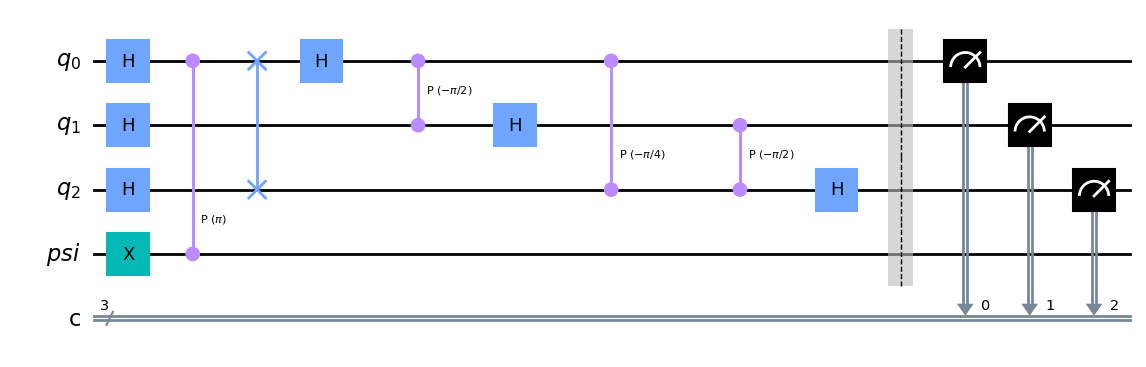

In [112]:
transpiled_qc.draw('mpl')

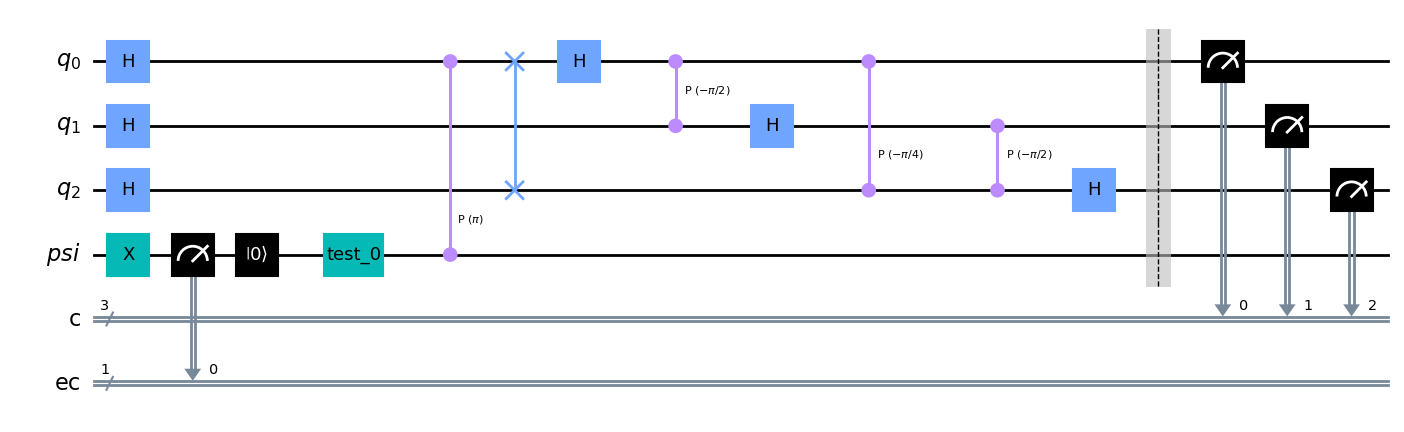

In [113]:
new_qc.draw('mpl')

In [205]:
for i in transpiled_qc.data:
    print(i)

CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=())
CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 1),), clbits=())
CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'flag'), 0),), clbits=())
CircuitInstruction(operation=Instruction(name='cp', num_qubits=2, num_clbits=0, params=[1.5707963267948966]), qubits=(Qubit(QuantumRegister(2, 'q'), 1), Qubit(QuantumRegister(1, 'flag'), 0)), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 1), Qubit(QuantumRegister(2, 'q'), 0)), clbits=())
CircuitInstruction(operation=Instruction(name='cp', num_qubits=2, num_clbits=0, params=[-1.5707963267948966]), qubits=(Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegi

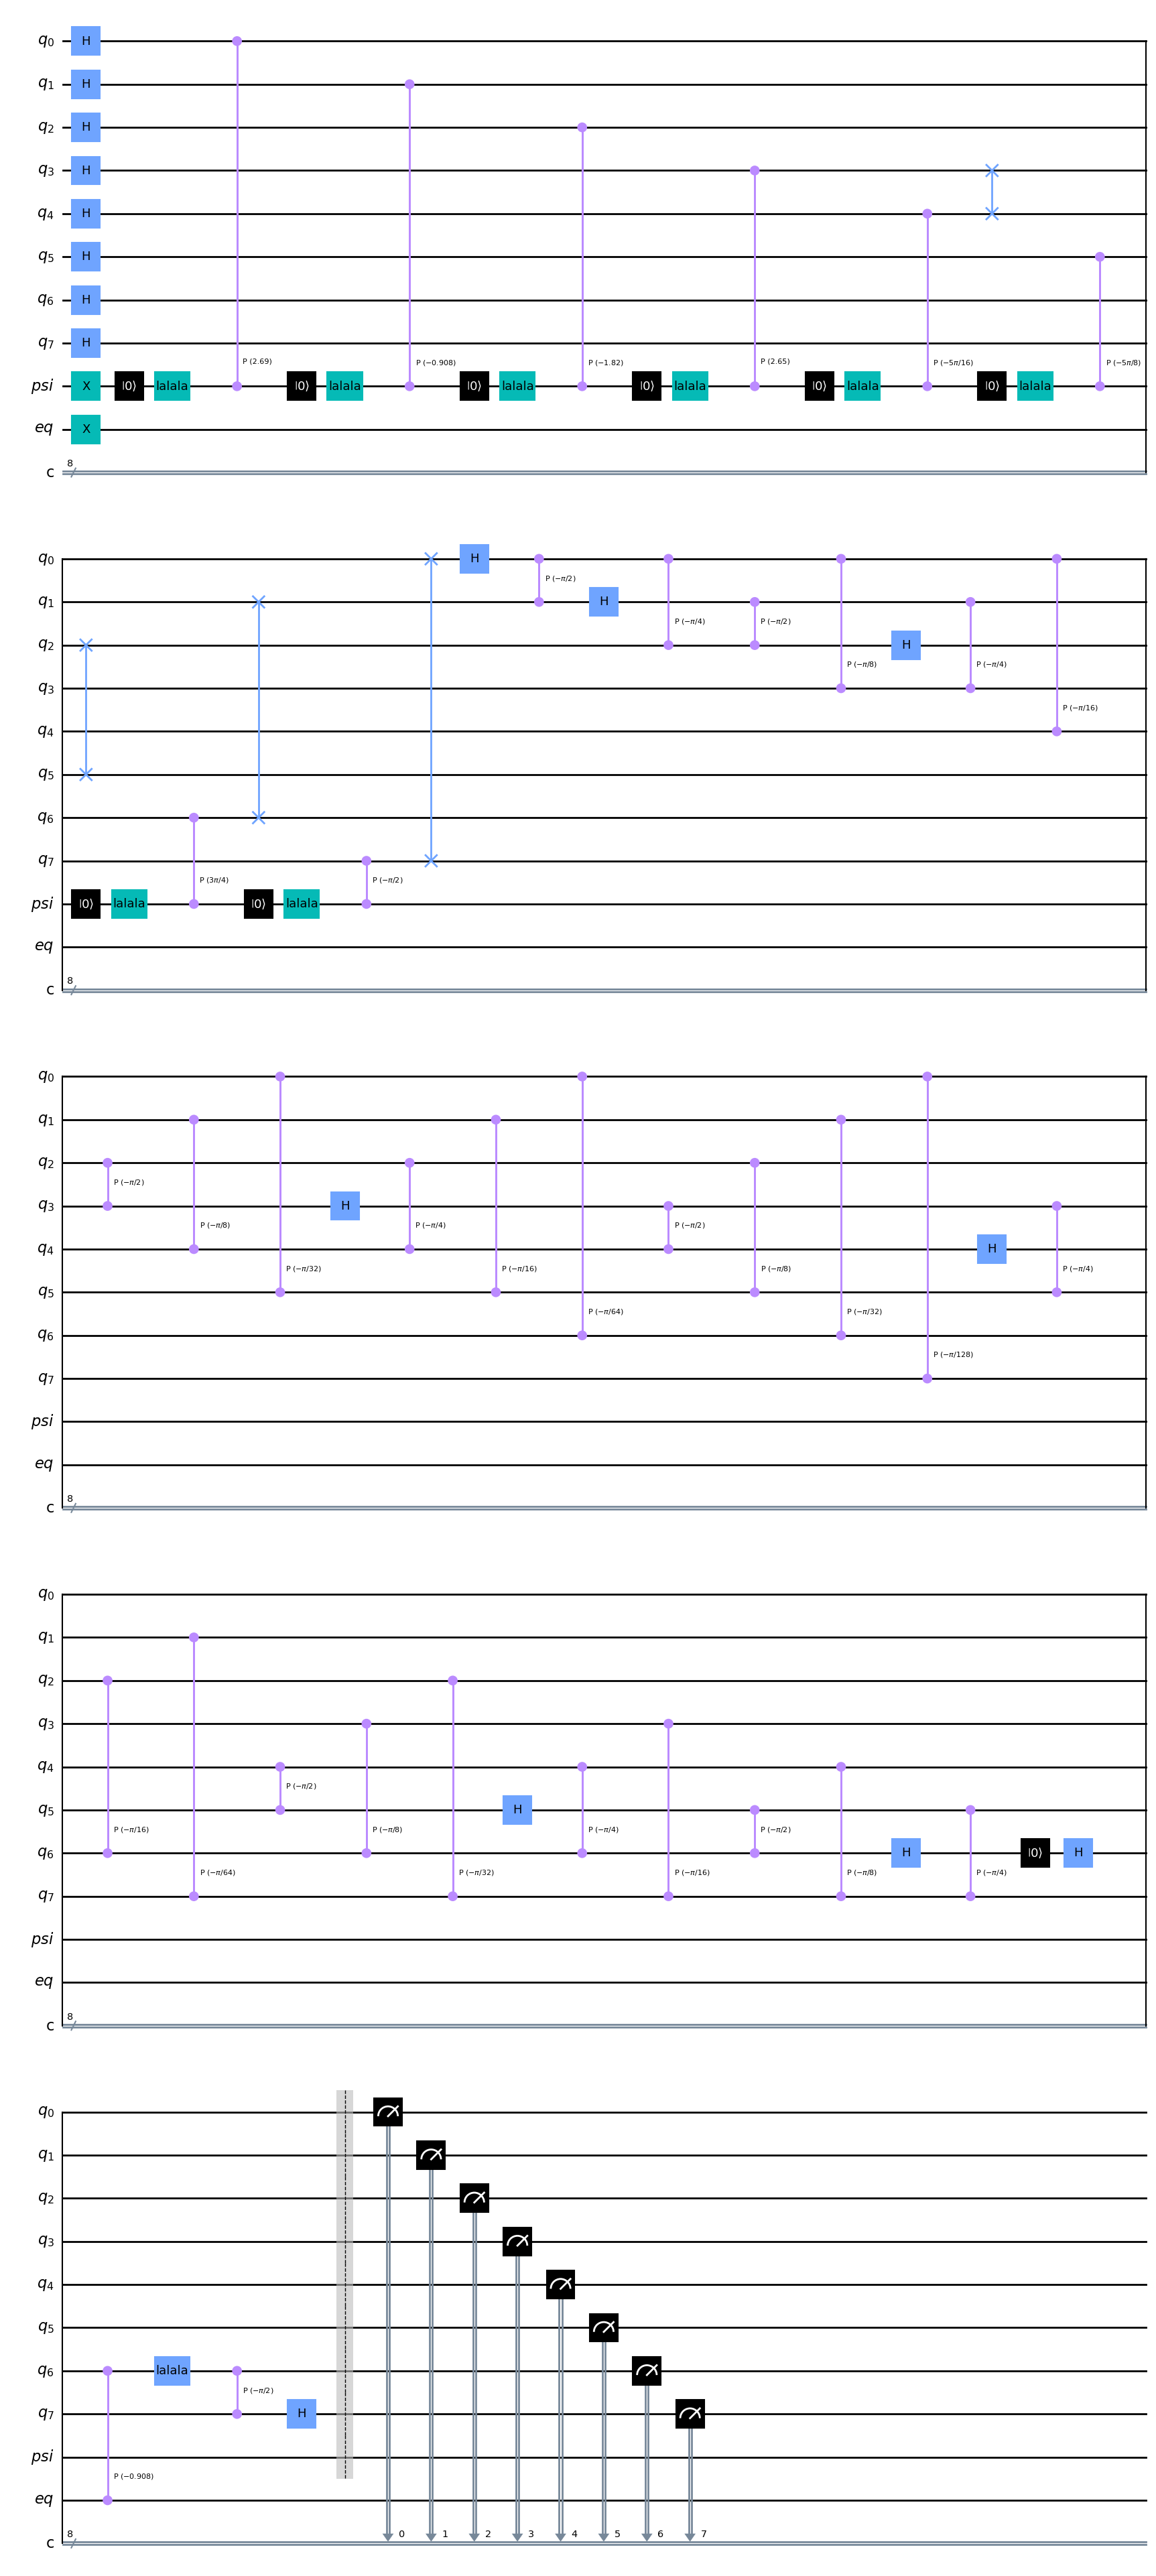

In [235]:
new_qc.draw('mpl')

In [114]:
def find_probablity_new(qc, simulator):
    res = []
    partial_circuit = QuantumCircuit()
    for reg in qc.qregs:
        new_reg = QuantumRegister(reg.size, reg.name)
        partial_circuit.add_register(new_reg)
    for reg in qc.cregs:
        new_reg = ClassicalRegister(reg.size, reg.name)
        partial_circuit.add_register(new_reg)
    # print(qc.num_qubits)
    # qc = transpile(qc, simulator)
    for i, gate in enumerate(qc.data):
        # 创建一个新的电路，将所有先前的门加入到新的电路中
        # partial_circuit = QuantumCircuit(qc.num_qubits)
        partial_circuit.data = qc.data[:i+1]  # 只包含到第 i 步的操作
        
    
        # 模拟部分电路并获取态向量
        job = simulator.run(partial_circuit)
        result = job.result()
        statevector = result.get_statevector()
        
        # 将态向量转换为量子态对象
        quantum_state = Statevector(statevector)
        # quantum_state = Statevector.from_instruction(partial_circuit)
    
        # 提取与该门操作相关的量子比特的状态
        qubits_involved = [partial_circuit.find_bit(qubit) for qubit in gate[1]]  # 获取与该门相关的量子比特
        for qubit in qubits_involved:
            # if gate[0].name == 'u3':
            #     print('sjhfjg;kg;r')
            # 使用 partial_trace 仅提取该量子比特的状态
            qubit_state = partial_trace(quantum_state, [q for q in range(qc.num_qubits) if q != qubit.index])
            prob_zero = qubit_state.data[0, 0].real
            prob_one = qubit_state.data[1, 1].real
            res.append([i, gate[0].name, qubit, prob_zero, prob_one, gate[0].params, gate[0].label])
    return res

In [115]:
result = {}
simulator = Aer.get_backend('statevector_simulator')
pm = PassManager(passes.RemoveFinalMeasurements())
for key, value in comparison_circuit.items():
    print(key)
    new_qc_no_meas = pm.run(value)
    result[key] =  find_probablity_new(new_qc_no_meas, simulator)

../quantum circuits/qpeinexact_indep_qiskit_13.qasm
../quantum circuits/vqe_indep_qiskit_6.qasm
../quantum circuits/qpeinexact_indep_qiskit_12.qasm
../quantum circuits/qpeexact_indep_qiskit_4.qasm
../quantum circuits/qpeinexact_indep_qiskit_15.qasm
../quantum circuits/qpeinexact_indep_qiskit_6.qasm
../quantum circuits/qpeexact_indep_qiskit_13.qasm
../quantum circuits/qpeexact_indep_qiskit_3.qasm
../quantum circuits/qpeinexact_indep_qiskit_19.qasm
../quantum circuits/qpeinexact_indep_qiskit_18.qasm
../quantum circuits/qpeexact_indep_qiskit_2.qasm
../quantum circuits/qpeexact_indep_qiskit_12.qasm
../quantum circuits/vqe_indep_qiskit_16.qasm
../quantum circuits/qpeinexact_indep_qiskit_7.qasm
../quantum circuits/qpeinexact_indep_qiskit_14.qasm
../quantum circuits/random_indep_qiskit_10.qasm
../quantum circuits/qpeinexact_indep_qiskit_4.qasm
../quantum circuits/random_indep_qiskit_2.qasm
../quantum circuits/qpeinexact_indep_qiskit_17.qasm
../quantum circuits/qpeinexact_indep_qiskit_8.qasm
.

In [7]:
count = 0
for key, value in result.items():
    print(key)
    flag = True
    for i in value:
        if (i[-1] and i[-1].split('_')[0] == 'test') and i[2][1][0][0].name != 'eq':
            if i[3] < 0.99 and i[4] < 0.99:
                print(i)
                flag = False
                continue
            # index = int(i[-1].split('_')[1])
            # if abs(i[3] - origin_result[key][index][0]) >= 1e-5 or abs(i[4] - origin_result[key][index][1])>= 1e-5:
            #     print(i, origin_result[key][index])
            #     flag = False
            #     continue
    print('***********************', '\n')
    if not flag:
        count += 1


print(count)

NameError: name 'result' is not defined

In [ ]:
for key in res_new:
    qc = QuantumCircuit.from_qasm_file(key)
    new_qc = comparison_circuit[key]
    result_qc = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=8192).result().get_counts()
    result_new_qc = execute(new_qc, backend=Aer.get_backend('qasm_simulator'), shots=8192).result().get_counts()
    print(result_qc, result_new_qc)
    print('\n', '*************************', '\n')

{'01001010010': 1, '01011010101': 4111, '01001010101': 4080} {'01001010001': 1, '01011010101': 4146, '01001010101': 4045}

 ************************* 

{'100': 242, '110': 3714, '001': 1865, '101': 1011, '111': 104, '011': 205, '010': 205, '000': 846} {'011': 209, '111': 114, '100': 224, '110': 3620, '001': 1963, '010': 219, '000': 869, '101': 974}

 ************************* 

{'1001': 8192} {'1 0111': 516, '1 0011': 521, '1 1101': 270, '1 1111': 103, '1 1001': 3496, '1 1011': 2962, '1 0101': 324}

 ************************* 

{'0000': 5, '1011': 680, '0110': 208, '0010': 1070, '1001': 212, '1111': 15, '1101': 1211, '0001': 675, '0011': 228, '0111': 310, '1010': 265, '0100': 1413, '1100': 977, '1000': 342, '1110': 505, '0101': 76} {'0000': 5, '0111': 296, '0110': 223, '0101': 80, '1001': 222, '0010': 1146, '1111': 17, '1101': 1237, '0011': 222, '0001': 661, '1100': 1039, '0100': 1342, '1110': 466, '1000': 338, '1010': 276, '1011': 622}

 ************************* 

{'01011001': 3, '10

In [204]:
count = 0
for i in result:
    if i[-1] == 'reset' and i[2][1][0][0].name != 'eq':
        print(i)
    # if i[1] != 'reset' and (i[3] >= 0.99 or i[4] >= 0.99):
    # if i[3] >= 0.99 or i[4] >= 0.99:
    #     if (i[1] in ['reset', 'u'] or [i[1], i[2], i[5]] in temp) and i[2].index == 1:
    #         print(i)
        # print(i)
    # print(i)    

[6, 'x', BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]), 0.0, 1.0, [], 'reset']
[9, 'x', BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]), 0.0, 1.0, [], 'reset']
[12, 'x', BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]), 0.0, 1.0, [], 'reset']
[15, 'x', BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]), 0.0, 1.0, [], 'reset']
[24, 'h', BitLocations(index=0, registers=[(QuantumRegister(4, 'q'), 0)]), 6.430140440293182e-32, 1.0000000000000002, [], 'reset']
[36, 'cp', BitLocations(index=0, registers=[(QuantumRegister(4, 'q'), 0)]), 6.403100671597512e-32, 1.0, [-1.5707963267948966], 'reset']
[42, 'h', BitLocations(index=1, registers=[(QuantumRegister(4, 'q'), 1)]), 0.5000000000000002, 0.5, [], 'reset']
[57, 'cp', BitLocations(index=0, registers=[(QuantumRegister(4, 'q'), 0)]), 5.841978497763808e-32, 1.0, [-0.7853981633974483], 'reset']
[64, 'cp', BitLocations(index=1, registers=[(QuantumRegister(4, 'q'), 1)]), 0.5, 0.5, 

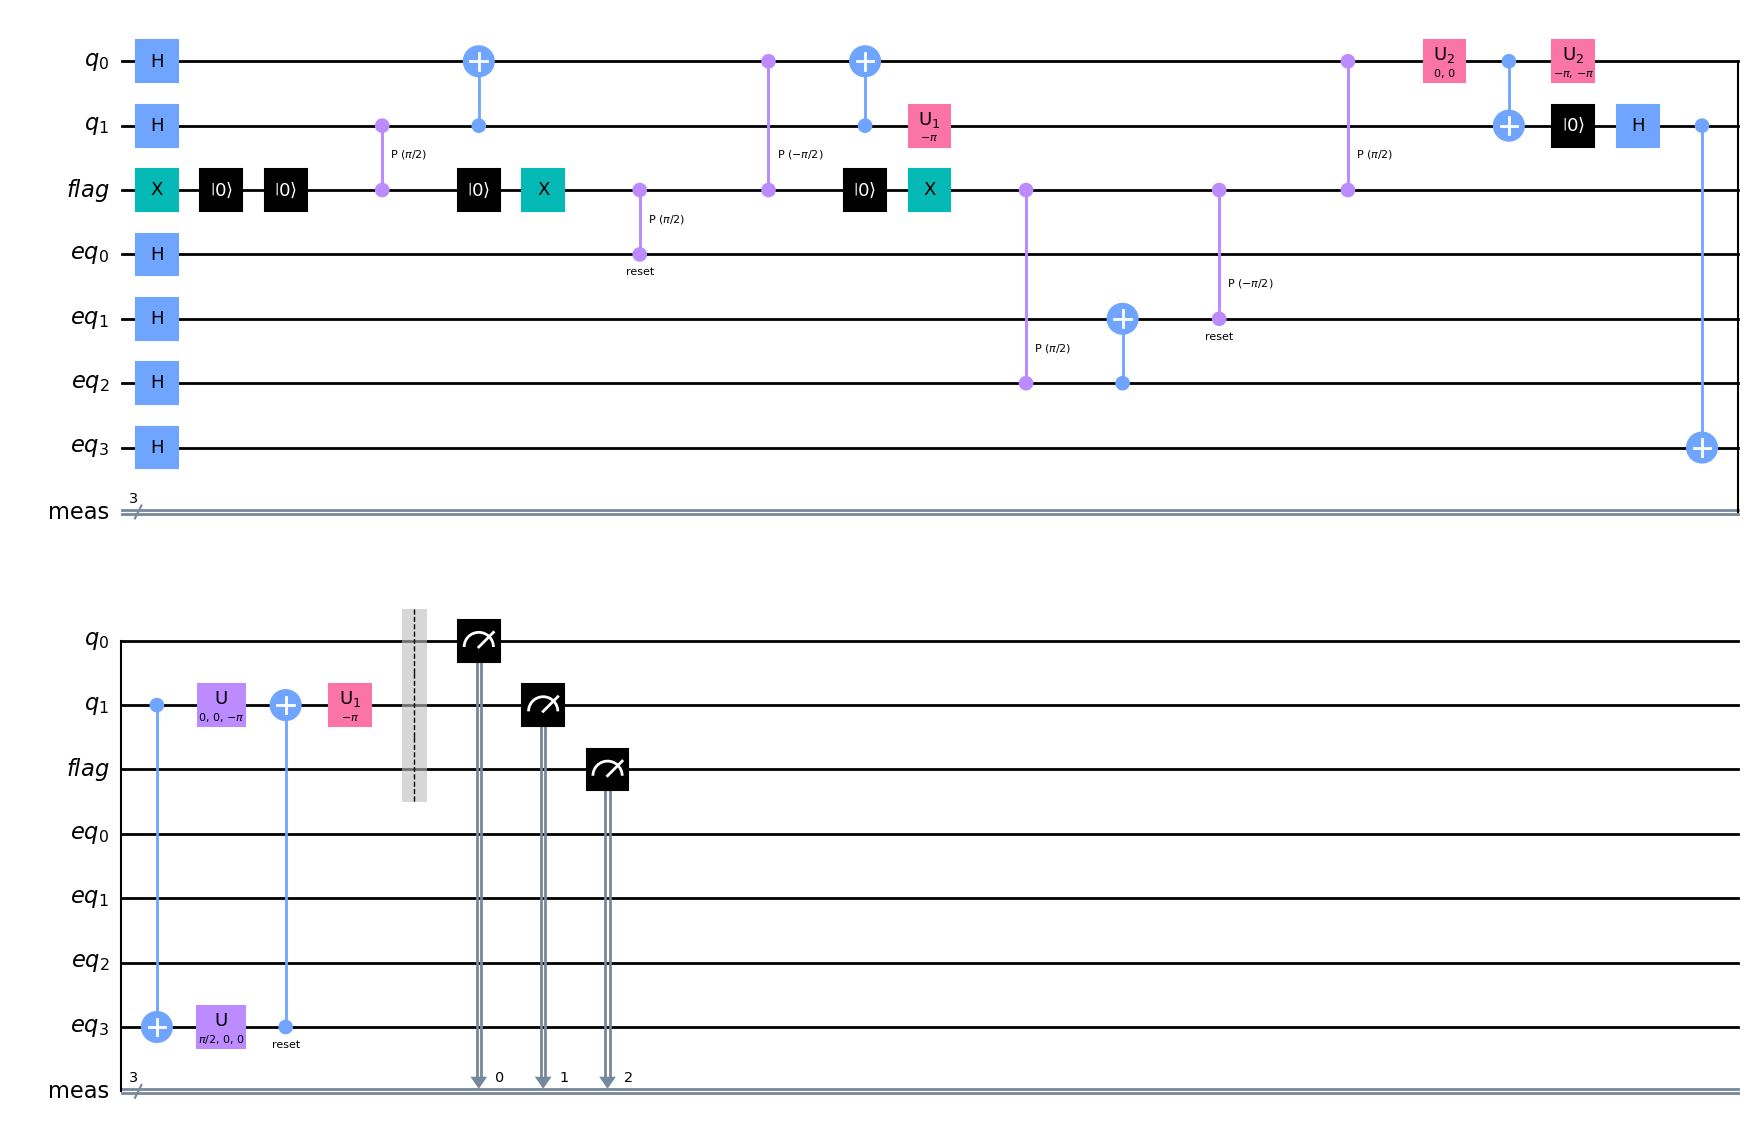

In [217]:
new_qc.draw('mpl')

In [216]:
for i in new_qc.data:
    print(i)

CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=())
CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 1),), clbits=())
CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'flag'), 0),), clbits=())
CircuitInstruction(operation=Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'flag'), 0),), clbits=())
CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'flag'), 0),), clbits=())
CircuitInstruction(operation=Instruction(name='cp', num_qubits=2, num_clbits=0, params=[1.5707963267948966]), qubits=(Qubit(QuantumRegister(2, 'q'), 1), Qubit(QuantumRegister(1, 'flag'), 0)), clbits=())
CircuitInstruction(operation=Instruction(name='re

In [226]:
from qiskit.providers.fake_provider import FakeWashington
from qiskit import Aer, transpile, execute

# qc = QuantumCircuit.from_qasm_file('../quantum_circuits/qpeexact_indep_qiskit_5.qasm')
# backend = Aer.get_backend('qasm_simulator')  # 使用模拟器
# result = execute(qc, backend, shots=8192).result()
# counts = result.get_counts()
# print(counts)

# 使用 FakeWashington 模拟器
fake_washington = FakeWashington()

# # 将量子电路转译为适应 FakeWashington
# transpiled_qc = transpile(qc, backend=fake_washington)

# 使用 Aer 运行器执行电路
result_1 = execute(transpiled_qc, backend=fake_washington, shots=8192).result()
print(result_1.get_counts())

{'00000': 15, '11100': 17, '11000': 34, '10001': 34, '01000': 44, '00010': 80, '10000': 16, '11001': 122, '11011': 153, '01001': 157, '01011': 191, '00001': 51, '11010': 74, '10101': 9, '00101': 30, '10010': 23, '01010': 157, '01110': 3632, '10011': 58, '10111': 15, '01101': 40, '01111': 185, '00011': 77, '11110': 699, '10100': 13, '00111': 72, '11111': 36, '11101': 13, '00110': 1613, '10110': 378, '00100': 53, '01100': 101}


In [227]:
result_2 = execute(new_qc, backend=fake_washington, shots=8192).result()
print(result_2.get_counts())

{'00000': 23, '00101': 25, '10101': 9, '00100': 32, '11111': 31, '10010': 18, '11000': 53, '00011': 79, '11010': 75, '00001': 60, '01001': 109, '11011': 199, '10111': 21, '01101': 49, '01110': 3727, '10011': 66, '01111': 183, '11110': 637, '10100': 7, '00111': 83, '01000': 45, '10001': 45, '01011': 136, '11101': 10, '00110': 1658, '10110': 319, '11100': 15, '01010': 155, '00010': 70, '10000': 16, '11001': 156, '01100': 81}


In [228]:
qc = QuantumCircuit.from_qasm_file('../quantum_circuits/vqe_indep_qiskit_9.qasm')

result_3 = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
print(result_3.get_counts())

{'00110': 2167, '01110': 6025}


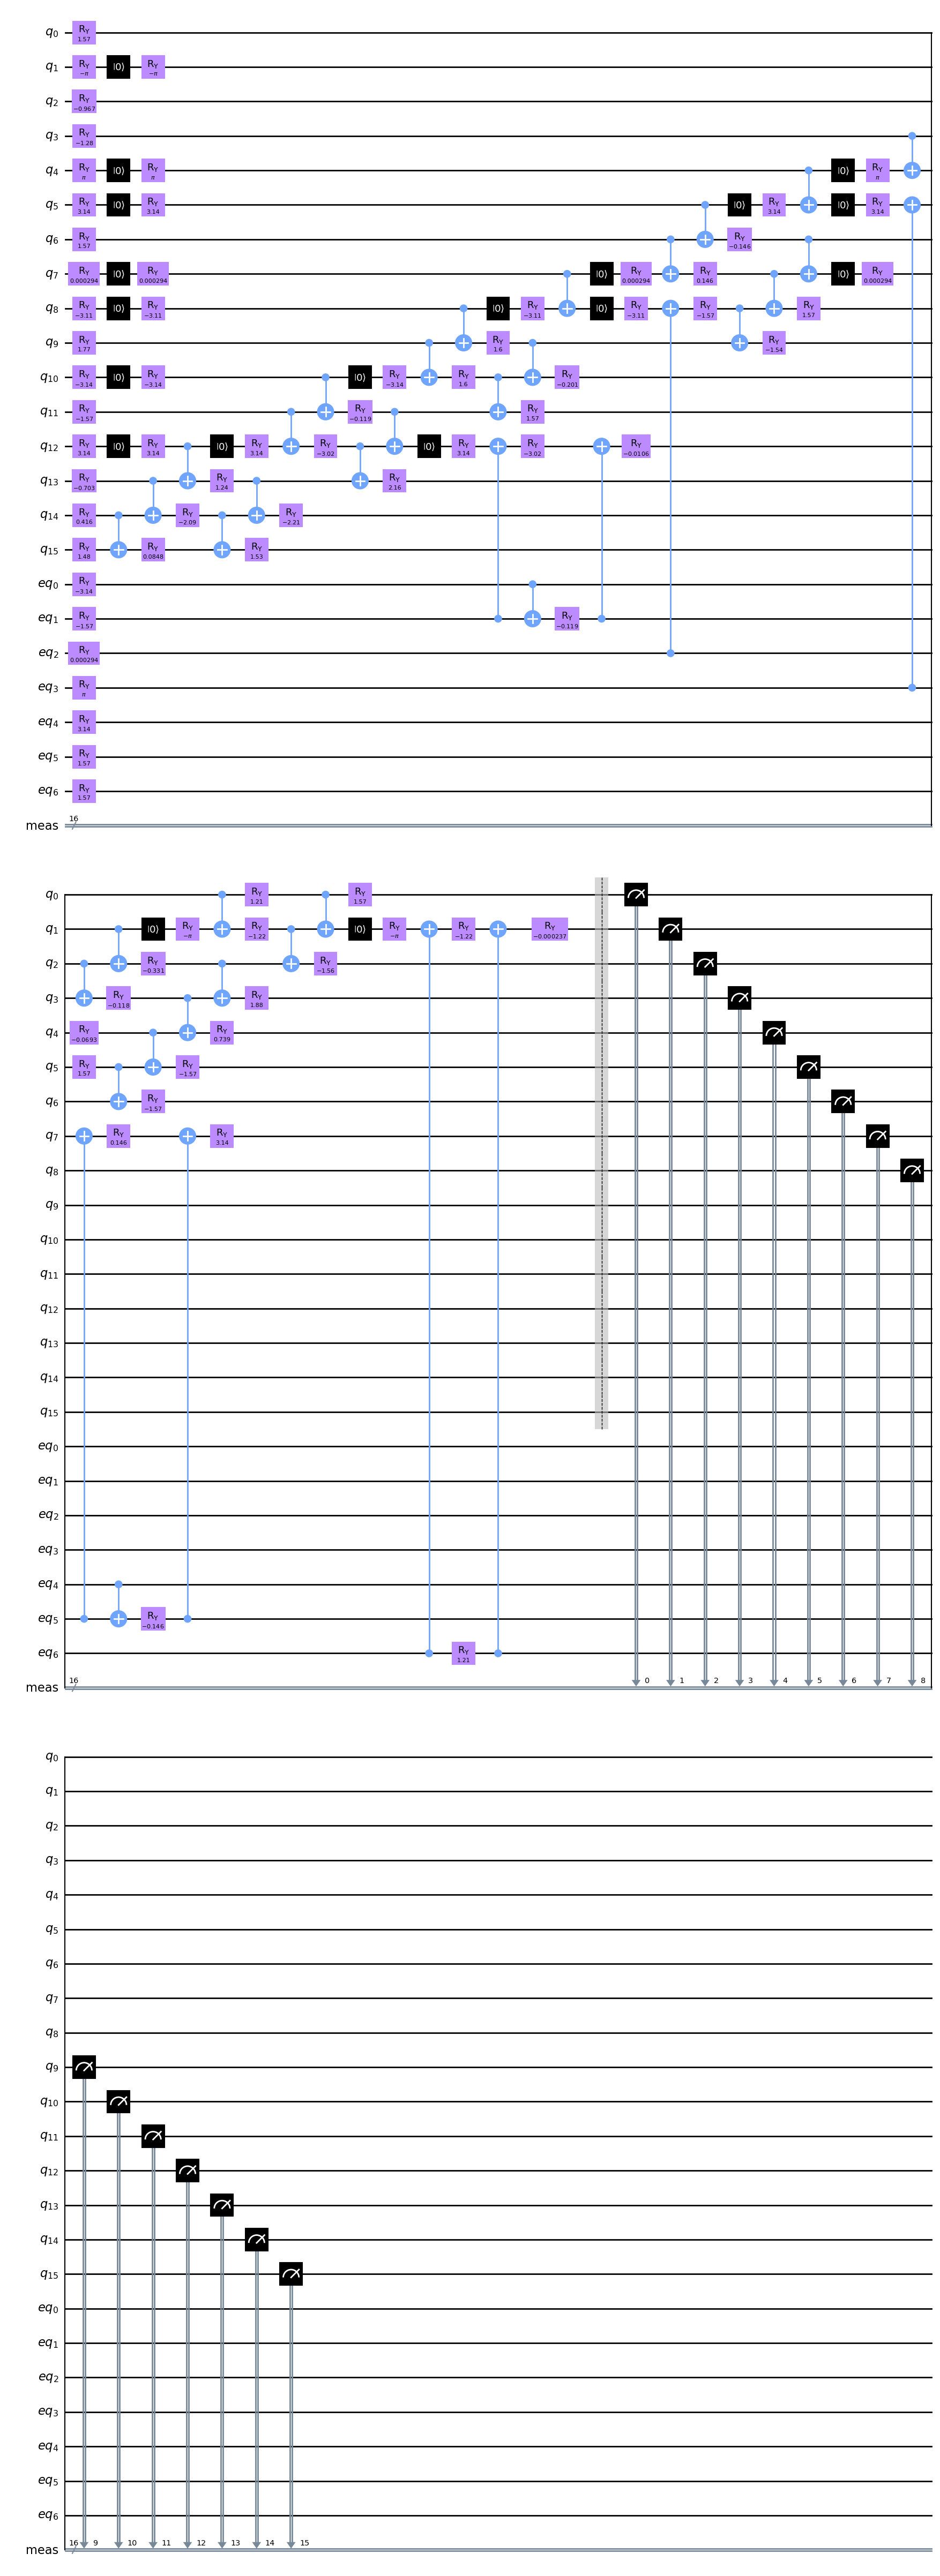

In [237]:
new_qc.draw('mpl')

In [218]:
for i in result:
    print(i)

[0, 'h', BitLocations(index=0, registers=[(QuantumRegister(4, 'q'), 0)]), 0.4999999999999999, 0.4999999999999999, []]
[1, 'h', BitLocations(index=1, registers=[(QuantumRegister(4, 'q'), 1)]), 0.4999999999999998, 0.4999999999999998, []]
[2, 'h', BitLocations(index=2, registers=[(QuantumRegister(4, 'q'), 2)]), 0.4999999999999998, 0.4999999999999998, []]
[3, 'h', BitLocations(index=3, registers=[(QuantumRegister(4, 'q'), 3)]), 0.4999999999999996, 0.4999999999999996, []]
[4, 'x', BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]), 0.0, 0.9999999999999996, []]
[5, 'reset', BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]), 1.0, 0.0, []]
[6, 'x', BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]), 0.0, 1.0, []]
[7, 'cp', BitLocations(index=4, registers=[(QuantumRegister(1, 'psi'), 0)]), 0.0, 1.0, [-2.748893571891069]]
[7, 'cp', BitLocations(index=0, registers=[(QuantumRegister(4, 'q'), 0)]), 0.5, 0.5, [-2.748893571891069]]
[8, 'reset', BitLocatio

In [1]:
simulator = Aer.get_backend('statevector_simulator')
pm = PassManager(passes.RemoveFinalMeasurements())
new_qc_no_meas = pm.run(new_qc)

result_portfoliovqe_indep_qiskit_6 =  find_probablity_new(new_qc_no_meas, simulator)

NameError: name 'Aer' is not defined

In [ ]:
temp = []
for i in definited_node_dict['../quantum_circuits/portfoliovqe_indep_qiskit_6.qasm']:
    # if i[2].index == 12:
    #     print(i)
    temp.append([i[1], i[2], i[6]])

for i in result_portfoliovqe_indep_qiskit_6:
    # if i[1] != 'reset' and (i[3] >= 0.99 or i[4] >= 0.99):
    if i[3] >= 0.99 or i[4] >= 0.99:
        if (i[1] == 'reset' or [i[1], i[2], i[5]] in temp):
            print(i)

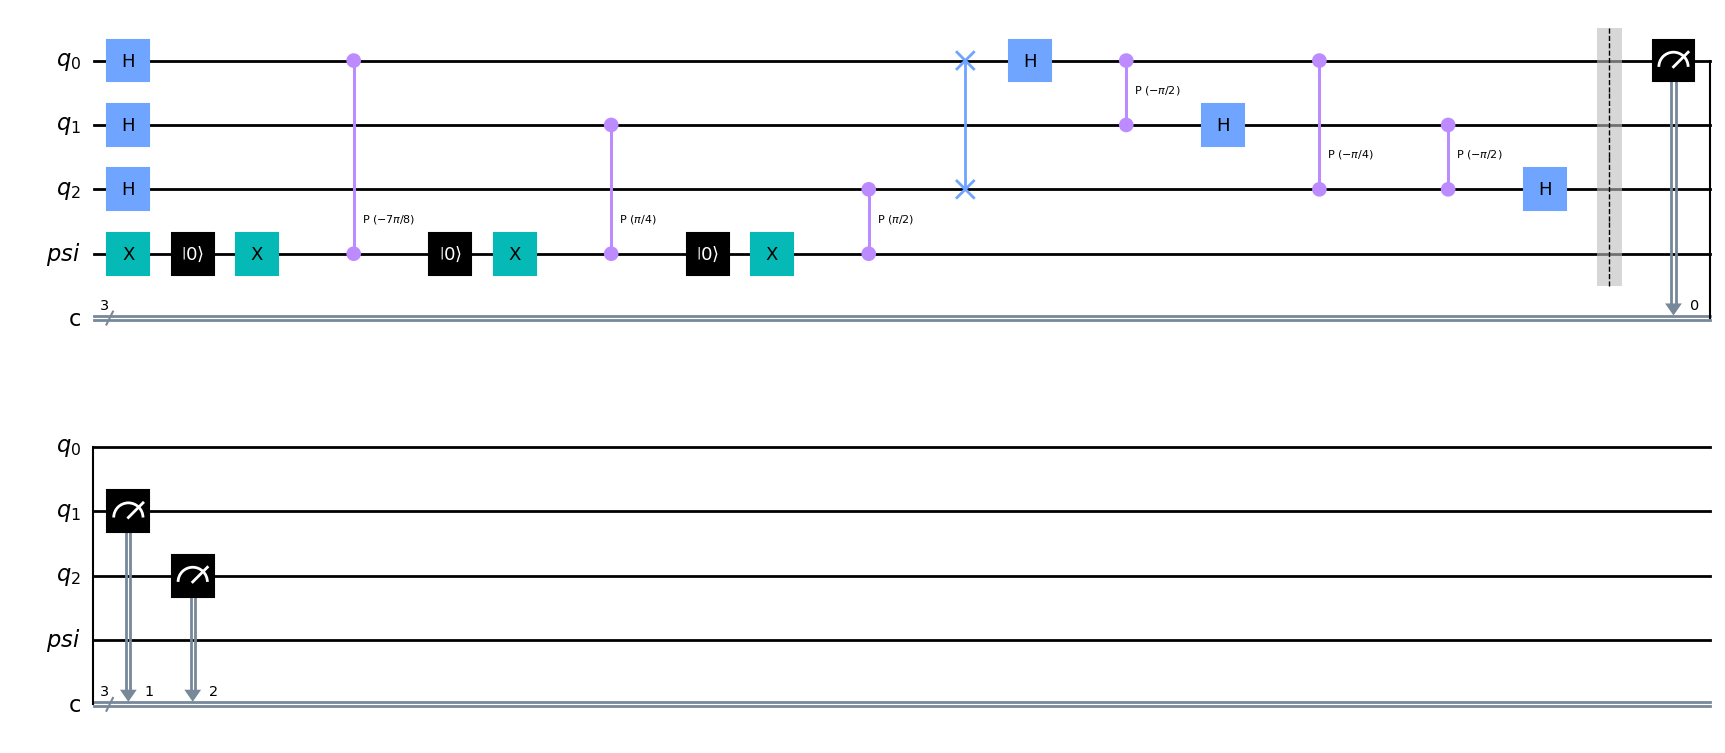

In [278]:
new_qc.draw('mpl')

In [ ]:
def main_function():
    f = open('../additional quantum_circuits/statevector_list.pkl', 'ab+')

    simulator = Aer.get_backend('statevector_simulator')
    
    folder_path = Path("../additional quantum_circuits/")  # 文件夹路径

    # result = {}

    # 递归遍历文件夹中的所有文件（包括子文件夹）
    for file in folder_path.rglob('*'):
        if file.is_file() and file.suffix == '.qasm':  # 检查文件是否以 .qasm 结尾
            print(file)
            try:
                qc = QuantumCircuit.from_qasm_file(file)
            except Exception as e:
                print(e)
                continue

            pm = PassManager(passes.RemoveFinalMeasurements())
            qc = pm.run(qc)

            res = find_probablity(file, qc, simulator)
            # print(res)
            # result[file] = res
            # print(result)
            # return
    
            pickle.dump([file, res], f)
            # break
    f.close()
            
    #         if find_def_state(qc, simulator):
    #             num += 1
            
    #         print(num)
    # return num
                